In [36]:
# importing necessary libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import numpy as np

## step 1
### data load and checking

In [37]:
# Define paths
data_path = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/metadata/Data_Entry_2017.csv"
image_folder = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/images/"

# Load the CSV file
df = pd.read_csv(data_path)

# Display the first few rows
print(df.head())

# Check how many unique labels exist
unique_labels = set()
for labels in df["Finding Labels"]:
    unique_labels.update(labels.split("|"))  # Split multi-label cases

print("Unique Disease Labels:", unique_labels)

# Load a sample image
sample_image = os.path.join(image_folder, df.iloc[0]["Image Index"])
img = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)

# Display the sample image
plt.imshow(img, cmap="gray")
plt.title(f"Sample X-ray: {df.iloc[0]['Finding Labels']}")
plt.axis("off")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/debabratapanda/PycharmProjects/Capstone/dataset/chest_xrays/metadata/Data_Entry_2017.csv'

Fractured images: 4606
Not Fractured images: 4640


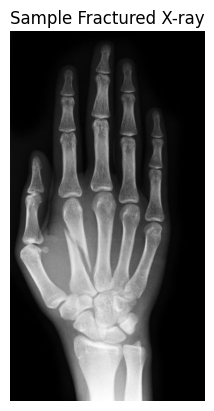

In [24]:
# Define paths
fracture_dir = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures"
fractured_path = os.path.join(fracture_dir, "fractured")
not_fractured_path = os.path.join(fracture_dir, "not_fractured")

# Check the number of images
print("Fractured images:", len(os.listdir(fractured_path)))
print("Not Fractured images:", len(os.listdir(not_fractured_path)))

# Load and display a sample fractured image
sample_image = os.path.join(fractured_path, os.listdir(fractured_path)[0])
img = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.title("Sample Fractured X-ray")
plt.axis("off")
plt.show()


# step 2
### EDA

In [25]:
# Load the CSV file
df = pd.read_csv(data_path)

# Create a dictionary to store condition counts
condition_counts = {}

# Count occurrences of each condition
for labels in df["Finding Labels"]:
    # For each image, split its conditions and count them
    conditions = labels.split("|")
    for condition in conditions:
        condition_counts[condition] = condition_counts.get(condition, 0) + 1

# Convert to DataFrame and sort by frequency
conditions_df = pd.DataFrame(
    list(condition_counts.items()),
    columns=['Condition', 'Count']
).sort_values('Count', ascending=False)

# Add percentage column
total_images = len(df)
conditions_df['Percentage'] = (conditions_df['Count'] / total_images * 100).round(2)

# Display the results
print("Total number of images:", total_images)
print("\nCondition Distribution:")
print(conditions_df)

Total number of images: 112120

Condition Distribution:
             Condition  Count  Percentage
3           No Finding  60361       53.84
5         Infiltration  19894       17.74
2             Effusion  13317       11.88
8          Atelectasis  11559       10.31
7               Nodule   6331        5.65
6                 Mass   5782        5.16
9         Pneumothorax   5302        4.73
14       Consolidation   4667        4.16
10  Pleural_Thickening   3385        3.02
0         Cardiomegaly   2776        2.48
1            Emphysema   2516        2.24
13               Edema   2303        2.05
12            Fibrosis   1686        1.50
11           Pneumonia   1431        1.28
4               Hernia    227        0.20


### image preprocessing

In [26]:
# Function to test our preprocessing
def visualize_preprocessing(image_path):
    """
    Visualize the original and preprocessed versions of an image.
    This helps us verify our preprocessing steps are working as intended.
    """
    # Load original image
    original = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    # Get preprocessed version
    processed = load_and_preprocess_image(image_path)

    # Display both images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(processed, cmap='gray')
    ax2.set_title('Preprocessed Image')
    ax2.axis('off')

    plt.show()

In [27]:
def load_and_preprocess_image(image_path, target_size=(224, 224), save_flag=False):
    """
    Load and preprocess an X-ray image with automatic folder creation for processed images.
    The processed images will be saved in a new folder that adds '_processed' to the original folder name.

    Args:
        image_path (str): Path to the original X-ray image
        target_size (tuple): Desired size for the processed image (default: 224x224)
        save_flag (bool): If True, save the processed image; if False, return it
    Returns:
        1. folder with processed images if save_flag is True
        2. A processed image that can be used directly
    """

    # loading greyscale xray images
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    # Checking if image was loaded successfully
    if image is None:
        print(f"Error: Failed to load image: {image_path}")
        return None

    # creating a try exception block for catching exceptions in images
    try:
        # Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) because
        # 1. it enhances the contrast of the X-ray while limiting noise amplification
        # 2. this in turn helps us in making subtle details more visible while preventing over-enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)

        # Resizing the image while maintaining aspect ratio we are doing this because
        # 1. We need a consistent image size for our neural network
        # 2. preserving the aspect ratio helps preserve the relative size of features in the image

        # getting the current dimensions
        current_height, current_width = image.shape

        # calculating the scaling
        scale = min(target_size[0] / current_width, target_size[1] / current_height)
        new_width = int(current_width * scale)
        new_height = int(current_height * scale)
        resized = cv2.resize(image, (new_width, new_height))

        # creating a black canvas of target size as it helps us in
        # 1. ensuring all images have exactly the same dimensions
        # 2. preserves their aspect ratios through padding
        final_image = np.zeros(target_size, dtype=np.float32)
        y_offset = (target_size[0] - new_height) // 2
        x_offset = (target_size[1] - new_width) // 2
        final_image[y_offset:y_offset + new_height,
        x_offset:x_offset + new_width] = resized

        # normalising pixel values to range [0,1] because
        # 1. helps with model convergence
        # 2. makes the learning process more stable
        final_image = final_image / 255.0

        # checking whether to save or return the image
        if save_flag:

            # creating folder name for processed images
            original_folder = os.path.dirname(image_path)
            processed_folder = original_folder + '_processed'

            # creating the folder for processed images
            os.makedirs(processed_folder, exist_ok=True)

            # recreate original output filenames
            base_name = os.path.basename(image_path)
            file_name = os.path.splitext(base_name)[0] + '.npy'     # Saving as .npy to preserve exact numerical values (0-1) and floating point precision for                                                             # training as using this would help us avoid the data loss that would occur with regular image
                                                                    # format (jpg/png) as they round the value whereas npy stores numerical arrays as it is
            save_path = os.path.join(processed_folder, file_name)

            # Saving the processed image
            np.save(save_path, final_image)
            return None
        else:
            return final_image


    except Exception as e:
        print(f"Error during processing: {str(e)}")
        return None

In [28]:
a = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/fractured"
b = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/not_fractured"
c = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/images"
fi = [a,b,c]
for i in fi:
    print(f"proceessing folder with {os.path.basename(i)} images")
    for image_name in tqdm(os.listdir(i)):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            input_path = os.path.join(i, image_name)
            load_and_preprocess_image(input_path, save_flag=True)

proceessing folder with fractured images


  0%|          | 0/4606 [00:00<?, ?it/s]

libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


Error: Failed to load image: /Users/debabratapanda/PycharmProjects/Capstone/dataset/bone_fractures/fractured/26(1).jpg


libpng warning: iCCP: known incorrect sRGB profile


Error: Failed to load image: /Users/debabratapanda/PycharmProjects/Capstone/dataset/bone_fractures/fractured/159.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: bKGD: invalid


Error: Failed to load image: /Users/debabratapanda/PycharmProjects/Capstone/dataset/bone_fractures/fractured/2.jpg


libpng warning: iCCP: known incorrect sRGB profile


KeyboardInterrupt: 

In [30]:
# 1. First, define paths where our preprocessed .npy files are stored
fracture_processed = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/fractured_processed"
not_fracture_processed = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/not_fractured_processed"
chest_processed = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/images_processed"

# Path to the CSV file containing chest X-ray labels
chest_csv_path = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/metadata/Data_Entry_2017.csv"

In [31]:
def create_dataset_df():
    """
    This function creates a unified DataFrame containing information about all our images
    """
    # For fracture dataset:
    # Create a list of tuples: (file_path, label, dataset_type)
    # Label 1 for fractured images
    fracture_files = [(os.path.join(fracture_processed, f), 1, 'fracture')
                      for f in os.listdir(fracture_processed) if f.endswith('.npy')]

    # Label 0 for non-fractured images
    not_fracture_files = [(os.path.join(not_fracture_processed, f), 0, 'not fracture')
                         for f in os.listdir(not_fracture_processed) if f.endswith('.npy')]

    # Combine fractured and non-fractured into one DataFrame
    fracture_df = pd.DataFrame(fracture_files + not_fracture_files,
                             columns=['file_path', 'fracture_label', 'dataset_type'])

    # For chest X-ray dataset:
    # First read the CSV containing labels
    chest_labels_df = pd.read_csv(chest_csv_path)

    # Create list of preprocessed chest X-ray files
    # Note: we replace .png with .npy since we preprocessed the images
    chest_files = [(os.path.join(chest_processed, f.replace('.png', '.npy')), f, 'chest')
                   for f in chest_labels_df['Image Index']]

    # Create DataFrame for chest X-rays
    chest_df = pd.DataFrame(chest_files,
                          columns=['file_path', 'original_filename', 'dataset_type'])

    # Merge with the original labels from CSV
    chest_df = chest_df.merge(chest_labels_df,
                            left_on='original_filename',
                            right_on='Image Index',
                            how='left')

    # Combine both fracture and chest datasets into one DataFrame
    combined_df = pd.concat([fracture_df, chest_df], ignore_index=True)

    return combined_df

In [32]:
# Create the organized DataFrame
dataset_df = create_dataset_df()

In [34]:
dataset_df

,file_path,fracture_label,dataset_type,original_filename,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121331,/Users/debabratapanda/PycharmProjects/Capstone...,NaN,chest,00030801_001.png,00030801_001.png,Mass|Pneumonia,1.0,30801.0,39.0,M,PA,2048.0,2500.0,0.168,0.168,NaN
121332,/Users/debabratapanda/PycharmProjects/Capstone...,NaN,chest,00030802_000.png,00030802_000.png,No Finding,0.0,30802.0,29.0,M,PA,2048.0,2500.0,0.168,0.168,NaN
121333,/Users/debabratapanda/PycharmProjects/Capstone...,NaN,chest,00030803_000.png,00030803_000.png,No Finding,0.0,30803.0,42.0,F,PA,2048.0,2500.0,0.168,0.168,NaN
121334,/Users/debabratapanda/PycharmProjects/Capstone...,NaN,chest,00030804_000.png,00030804_000.png,No Finding,0.0,30804.0,30.0,F,PA,2048.0,2500.0,0.168,0.168,NaN


In [33]:
# Print information about our dataset
print("Total number of images:", len(dataset_df))
print("\nDataset distribution:")
print(dataset_df['dataset_type'].value_counts())

Total number of images: 121336

Dataset distribution:
dataset_type
chest       112120
fracture      9216
Name: count, dtype: int64
